# Single-cell RNA-seqs analysis using Python  
## Exercises 03: Batch correction and data integration

Adapted from:  
Single-cell best practices  
www.sc-best-practices.org

This exercise uses the same input data with the practicals_03 of this course

Work in groups, answer the questions and run the code

## 1.  Load dependencies
Activate the conda environment `sc_py_intg` to run this notebook.  
```
conda activate sc_py_intg
```

In [1]:
# package dependencies and suppress unnecessary warning messages 
from numba.core.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning, NumbaWarning
import warnings

warnings.simplefilter('ignore', category=NumbaDeprecationWarning)
warnings.simplefilter('ignore', category=NumbaPendingDeprecationWarning)
warnings.simplefilter('ignore', category=NumbaWarning)

In [2]:
import scanpy as sc
import bbknn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

In [3]:
pd.set_option('display.max_columns', 40)

In [4]:
import harmonypy
import mnnpy

In [5]:
# reproducibility
seed = 10
np.random.seed(seed)

## 2.  Load and prepare input data

In [11]:
adata_raw = adata_raw = sc.read_h5ad(
    "../../training_data/openproblems_bmmc_multiome_genes_filtered.h5ad"
)

In [12]:
adata_raw

AnnData object with n_obs × n_vars = 69249 × 129921
    obs: 'GEX_pct_counts_mt', 'GEX_n_counts', 'GEX_n_genes', 'GEX_size_factors', 'GEX_phase', 'ATAC_nCount_peaks', 'ATAC_atac_fragments', 'ATAC_reads_in_peaks_frac', 'ATAC_blacklist_fraction', 'ATAC_nucleosome_signal', 'cell_type', 'batch', 'ATAC_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker'
    var: 'feature_types', 'gene_id'
    uns: 'ATAC_gene_activity_var_names', 'dataset_id', 'genome', 'organism'
    obsm: 'ATAC_gene_activity', 'ATAC_lsi_full', 'ATAC_lsi_red', 'ATAC_umap', 'GEX_X_pca', 'GEX_X_umap'
    layers: 'counts'

In [13]:
# set raw counts as the main matrix
adata_raw.X = adata_raw.layers['counts']

In [14]:
adata_raw.obs.head(n=2)

,GEX_pct_counts_mt,GEX_n_counts,GEX_n_genes,GEX_size_factors,GEX_phase,ATAC_nCount_peaks,ATAC_atac_fragments,ATAC_reads_in_peaks_frac,ATAC_blacklist_fraction,ATAC_nucleosome_signal,cell_type,batch,ATAC_pseudotime_order,GEX_pseudotime_order,Samplename,Site,DonorNumber,Modality,VendorLot,DonorID,DonorAge,DonorBMI,DonorBloodType,DonorRace,Ethnicity,DonorGender,QCMeds,DonorSmoker
TAGTTGTCACCCTCAC-1-s1d1,1.061008,1508.0,1022,0.453484,S,4031.0,5400,0.746481,0.003473,0.642468,Naive CD20+ B,s1d1,NaN,NaN,site1_donor1_multiome,site1,donor1,multiome,3054455,15078,34,24.8,B-,White,HISPANIC OR LATINO,Male,False,Nonsmoker
CTATGGCCATAACGGG-1-s1d1,0.604230,1655.0,1081,0.455631,G2M,8636.0,19266,0.448251,0.003126,1.220679,CD14+ Mono,s1d1,NaN,NaN,site1_donor1_multiome,site1,donor1,multiome,3054455,15078,34,24.8,B-,White,HISPANIC OR LATINO,Male,False,Nonsmoker


#### let's take a look at all samples from donor 1

In [15]:
adata_raw[adata_raw.obs.DonorNumber == 'donor1'].obs['Site'].value_counts()
# we have 3 sites (samples) from donor 1

site4    8023
site1    6224
site2    4220
Name: Site, dtype: int64

In [16]:
adata = adata_raw[adata_raw.obs.DonorNumber == 'donor1'].copy()
adata

AnnData object with n_obs × n_vars = 18467 × 129921
    obs: 'GEX_pct_counts_mt', 'GEX_n_counts', 'GEX_n_genes', 'GEX_size_factors', 'GEX_phase', 'ATAC_nCount_peaks', 'ATAC_atac_fragments', 'ATAC_reads_in_peaks_frac', 'ATAC_blacklist_fraction', 'ATAC_nucleosome_signal', 'cell_type', 'batch', 'ATAC_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker'
    var: 'feature_types', 'gene_id'
    uns: 'ATAC_gene_activity_var_names', 'dataset_id', 'genome', 'organism'
    obsm: 'ATAC_gene_activity', 'ATAC_lsi_full', 'ATAC_lsi_red', 'ATAC_umap', 'GEX_X_pca', 'GEX_X_umap'
    layers: 'counts'

In [17]:
# Only keep gene expression features as the original data is a multiome dataset

adata.var["feature_types"].value_counts()

ATAC    116490
GEX      13431
Name: feature_types, dtype: int64

In [18]:
adata = adata[:, adata.var["feature_types"] == "GEX"].copy()
sc.pp.filter_genes(adata, min_cells=1)
adata

AnnData object with n_obs × n_vars = 18467 × 13431
    obs: 'GEX_pct_counts_mt', 'GEX_n_counts', 'GEX_n_genes', 'GEX_size_factors', 'GEX_phase', 'ATAC_nCount_peaks', 'ATAC_atac_fragments', 'ATAC_reads_in_peaks_frac', 'ATAC_blacklist_fraction', 'ATAC_nucleosome_signal', 'cell_type', 'batch', 'ATAC_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker'
    var: 'feature_types', 'gene_id', 'n_cells'
    uns: 'ATAC_gene_activity_var_names', 'dataset_id', 'genome', 'organism'
    obsm: 'ATAC_gene_activity', 'ATAC_lsi_full', 'ATAC_lsi_red', 'ATAC_umap', 'GEX_X_pca', 'GEX_X_umap'
    layers: 'counts'

---
**Question 1: if we plan to integrate data from donor one, fill in the label_key and batch_key**


In [19]:
## Answer 1

label_key = 'cell_type'
batch_key = 'Site'

## 3.  Data integration
### 1. First check unintegrated data

In [20]:
# standard analysis without considering batch

adata.X = adata.layers["counts"].copy()
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
adata.layers["logcounts"] = adata.X.copy()

In [21]:
sc.pp.highly_variable_genes(adata)
sc.tl.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
adata

AnnData object with n_obs × n_vars = 18467 × 13431
    obs: 'GEX_pct_counts_mt', 'GEX_n_counts', 'GEX_n_genes', 'GEX_size_factors', 'GEX_phase', 'ATAC_nCount_peaks', 'ATAC_atac_fragments', 'ATAC_reads_in_peaks_frac', 'ATAC_blacklist_fraction', 'ATAC_nucleosome_signal', 'cell_type', 'batch', 'ATAC_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker'
    var: 'feature_types', 'gene_id', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'ATAC_gene_activity_var_names', 'dataset_id', 'genome', 'organism', 'log1p', 'hvg', 'pca', 'neighbors', 'umap'
    obsm: 'ATAC_gene_activity', 'ATAC_lsi_full', 'ATAC_lsi_red', 'ATAC_umap', 'GEX_X_pca', 'GEX_X_umap', 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts', 'logcounts'
    obsp: 'distances', 'connectivities'

In [22]:
matplotlib.rcParams['figure.figsize'] = [3, 6]

In [39]:
batch_key

'Site'

/nfs/research/icortes/ysong/anaconda3/envs/sc_course_intg/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/nfs/research/icortes/ysong/anaconda3/envs/sc_course_intg/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


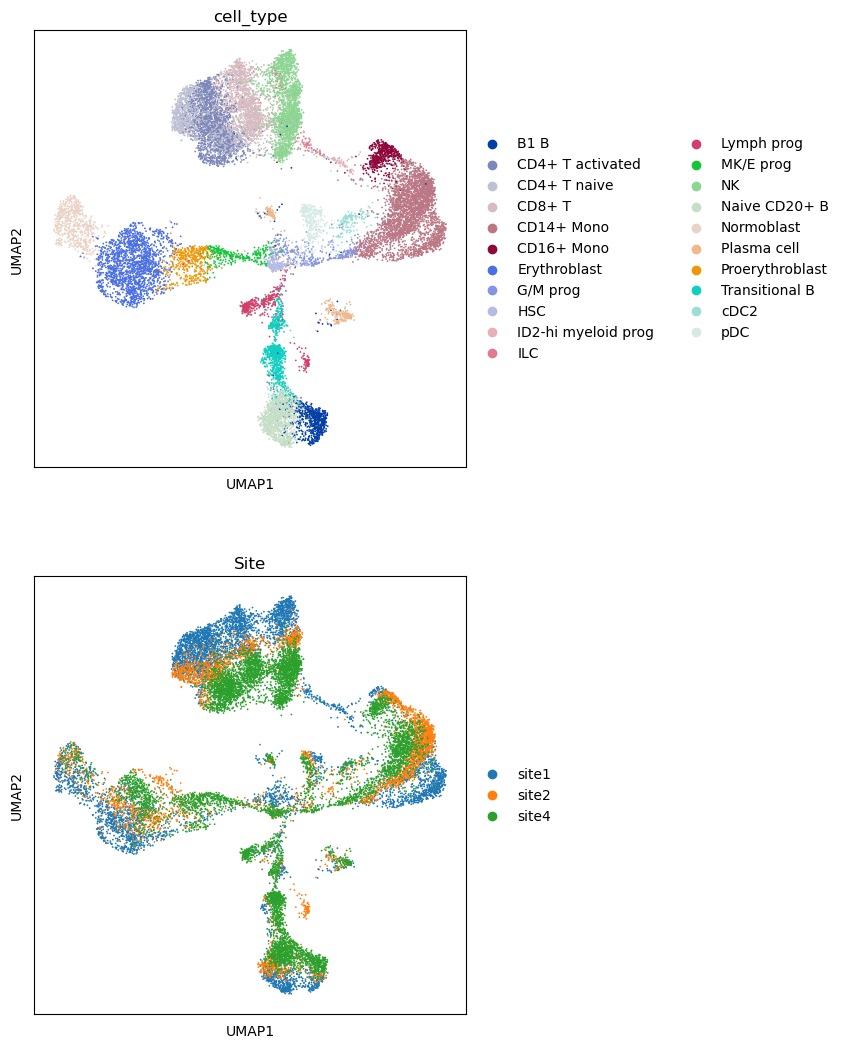

In [23]:
sc.pl.umap(adata, color=[label_key, batch_key], wspace=1, ncols=1)

---
**Question 2: based on the unintegrated data, shall we perform batch correction? What are the reasons?**


**Answer 2**

In this case, it very much depend on the goal. The batch effect is not huge so it might be interesting to explore the site variations, if you have knowledge about the sample acquisition. However if you want to identify cell groups and annotate cell types, it is worth performing data integration. Clustering on the integrated data will help you identify the correct cell types.

You might also consider manual annotation of single datasets (if manageable) or reference mapping to get a draft annotation, and plot the data for cell tyoe and batch then decide whether you need an integration.


### 2. Batch-aware feature selection

---
**Question 3: write and run the line of code to perform batch-aware highly variable genes (HVGs) selection**


In [24]:
# Answer 3
sc.pp.highly_variable_genes(adata, batch_key=batch_key, min_mean=0.0125, max_mean=3, min_disp=0.5)

/nfs/research/icortes/ysong/anaconda3/envs/sc_course_intg/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:478: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hvg = hvg.append(missing_hvg, ignore_index=True)
/nfs/research/icortes/ysong/anaconda3/envs/sc_course_intg/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:478: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hvg = hvg.append(missing_hvg, ignore_index=True)
/nfs/research/icortes/ysong/anaconda3/envs/sc_course_intg/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:478: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hvg = hvg.append(missing_hvg, ignore_index=True)


0    9370
1    2134
3    1014
2     913
Name: highly_variable_nbatches, dtype: int64

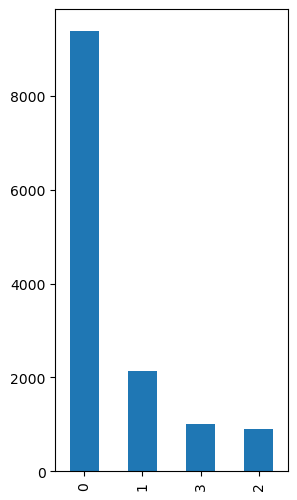

In [25]:
# see how many batches the gene is highly variable in

n_batches = adata.var["highly_variable_nbatches"].value_counts()
ax = n_batches.plot(kind="bar")
n_batches

In [26]:
# move the unintegrated umap
adata.obsm['X_umapraw'] = adata.obsm['X_umap']

### 3. Integration with harmony

---
**Question 4: write and run the line of code to perform harmony integration based on PCA**


In [27]:
# Answer 4
# run harmony via scanpy external API
sc.external.pp.harmony_integrate(adata, key=batch_key, basis='X_pca')

2023-09-20 11:26:52,721 - harmonypy - INFO - Iteration 1 of 10
2023-09-20 11:27:34,591 - harmonypy - INFO - Iteration 2 of 10
2023-09-20 11:28:17,239 - harmonypy - INFO - Iteration 3 of 10
2023-09-20 11:28:58,095 - harmonypy - INFO - Iteration 4 of 10
2023-09-20 11:29:31,268 - harmonypy - INFO - Iteration 5 of 10
2023-09-20 11:29:44,023 - harmonypy - INFO - Iteration 6 of 10
2023-09-20 11:29:46,142 - harmonypy - INFO - Iteration 7 of 10
2023-09-20 11:29:52,748 - harmonypy - INFO - Iteration 8 of 10
2023-09-20 11:30:03,493 - harmonypy - INFO - Iteration 9 of 10
2023-09-20 11:30:06,095 - harmonypy - INFO - Converged after 9 iterations


In [28]:
# recalculate neighbours and umap based on harmony corrected embedding

sc.pp.neighbors(adata, use_rep='X_pca_harmony', key_added = 'harmony', n_neighbors=15, n_pcs=40)
sc.tl.umap(adata, neighbors_key = 'harmony')

In [29]:
matplotlib.rcParams['figure.figsize'] = [5, 6]

/nfs/research/icortes/ysong/anaconda3/envs/sc_course_intg/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/nfs/research/icortes/ysong/anaconda3/envs/sc_course_intg/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


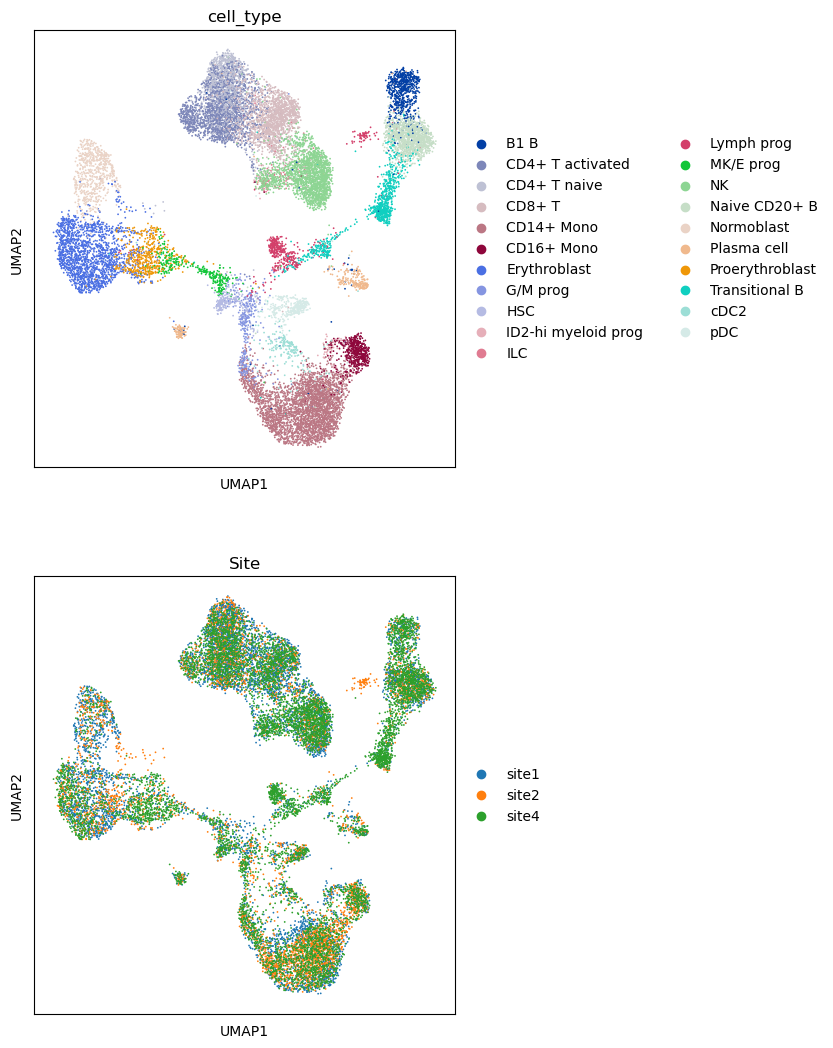

In [30]:
sc.pl.umap(adata, color=[label_key, batch_key], ncols=1)

In [31]:
# move harmony corrected umap
adata.obsm['X_umapharmony'] = adata.obsm['X_umap']

---
**Question 5: please answer if the following elements in the final anndata object is changed after data integration with harmony**
1. Raw count matrix
2. Log1p normalized count matrix
3. scaled count matrix
4. Highly variable genes list
5. Original PCA embedding
6. The embedding used to calculate neighbours
7. Neighbours
8. UMAP embedding

**what if bbknn is run instead? please list the elements that are changed in the final anndata object**

**what if mnn_correct is run instead? please list the elements that are changed in the final anndata object**

**Answer 5**

Harmony: 6, 7, 8 changed

bbknn: 7, 8 changed

mnn_correct: 3, 4, 5, 6, 7, 8 changed

---
**Question 6: 
We know that algorithms such as mnn_correct in Python or Seurat CCA/RPCA in R can generate corrected pseudo-counts**

**Discuss whether this count is suitable for performing differential expression analysis between cell types, and what are the reasons?**



**Answer 6**

Short answer: NO, don't use pseudocounts for DE analysis. 

https://github.com/satijalab/seurat/discussions/4032

https://github.com/satijalab/seurat/discussions/4000

#### The end